# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary

In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from IPython.display import display

# Config

## Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [5]:
df = pd.read_csv('/kaggle/input/ai-ca5-csv/ca5/data.csv')
df

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1
...,...,...
9114,have you ever laid on your bed at night and cr...,1
9115,the fault the blame the pain s still there i m...,1
9116,stop asking me to trust you when i m still cou...,1
9117,i never know how to handle sadness crying make...,1


## Data Preprocessing

In [6]:
import nltk
import emoji
import re
import string

import subprocess
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"],download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /kaggle/working/...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflati

In [7]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""
    return emoji.demojize(text)

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # TODO: lowercase the text
    text = text.lower()

    # TODO: remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # TODO: remove numbers
    text = text.translate(str.maketrans('', '', string.digits))

    # TODO: remove urls,
    text = re.sub(r'http\S+|www.\S+', '', text)

    # TODO: remove usernames
    text = re.sub(r'@\S+', '', text)

    # TODO: remove extra spaces
    text = re.sub(' +', ' ', text)

    # TODO: convert emojis to text
    text = convert_emoji_to_text(text)

    # TODO: remove non-word characters
    text = re.sub(r'[^a-z ]+', '', text)

    # TODO: lemmatization and tokenization of the text
    tokens = [nltk.WordNetLemmatizer().lemmatize(word) for word in nltk.word_tokenize(text)]

    # TODO: remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


In [8]:
## TODO: Show some samples before/after preprocessing
display(df.iloc[0].tweet, ' '.join(preprocess_data(df.iloc[0].tweet)))
display(df.iloc[1].tweet, ' '.join(preprocess_data(df.iloc[1].tweet)))

'my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives'

'life meaningless want end life badly life completely empty dont want create meaning creating meaning pain long hold back urge run car head first next person coming opposite way stop feeling jealous tragic character like gomer pile swift end able bring life'

'muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels '

'muttering wan na die daily month feel worthless shes soulmate cant live horrible world without lonely wish could turn part brain feel'

In [9]:
# df['tweet'] = df['tweet'].apply(preprocess_data)

In [10]:
tmp = pd.DataFrame()
tmp['label'] = df['intention']
tmp['len'] = df['tweet'].apply(lambda x: len(x))

In [11]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

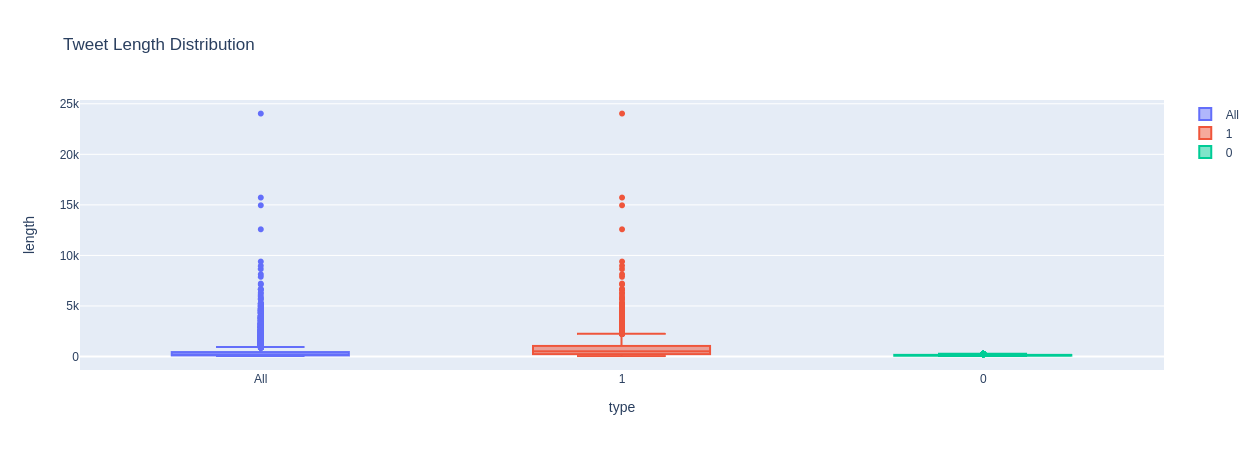

In [12]:
fig = go.Figure()
fig.add_box(y=tmp['len'], name='All')
fig.add_box(y=tmp[tmp['label'] == 1]['len'], name='1')
fig.add_box(y=tmp[tmp['label'] == 0]['len'], name='0')

fig.update_layout(
            title="Tweet Length Distribution",
            xaxis_title='type',
            yaxis_title='length',
        )

fig.show()

# Word2Vec - Word Embedding

In [13]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
W2V_PATH = '/kaggle/working/word2vec-google-news-300.bin'
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[=-------------------------------------------------] 2.8% 45.8/1662.8MB downloaded

In [29]:
W2V_PATH = '/kaggle/working/word2vec-google-news-300.bin'

w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')

In [30]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

In [31]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = []
        for word in tokens:
            if word in self.w2v_model:
                vectors.append(self.w2v_model[word])
            else:
                vectors.append(np.zeros(self.vector_size))
        return  self._to_tensor(vectors)



    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        tokens_len = len(tokens)
        if tokens_len < self.max_sequence_len:
            pad_num = self.max_sequence_len - tokens_len
            pad_vector = [0]*pad_num
            pad_tokens = tokens + pad_vector
        else:
            pad_tokens = tokens[:self.max_sequence_len]
        return pad_tokens
    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [32]:
train, validation = train_test_split(df, test_size=0.2, random_state=0)

## Create Datasets

In [33]:
# TODO: create twitter dataset
train_dataset = Twitter(
    train, w2v_model, SEQUENCE_LEN
)
valid_dataset = Twitter(
    validation, w2v_model, SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 28


/tmp/ipykernel_34/41410751.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_34/41410751.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Deleted 0-Len Samples: 8


/tmp/ipykernel_34/41410751.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_34/41410751.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Train dataset length: 7267
Valid dataset length: 1816


# Model and Train

## Utils

In [44]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    total = 0
    correct = 0

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        # TODO: calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # TODO: calculate/update model's accuracy
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_acc = correct / total


        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc

In [45]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    correct = 0
    total = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for idx, (inputs, labels) in enumerate(itr, start=1):
            # TODO: move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # TODO: use model's forward pass to generate outputs
            outputs = model(inputs)

            # TODO: process model's predictipns and calculate/update accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_acc = correct / total

            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # TODO: 1. clear optimizer's state and zero prev grads,
            optimizer.zero_grad()
            # TODO: 2. backward calculated loss
            loss.backward()
            # TODO: 3. step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )
            
        epoch_loss /= len(train_loader)
        epoch_acc = correct / total

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [36]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [37]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    # TODO: labels = true labels from the dataset
    # TODO: predicted = labels predicted by the model
    all_labels = []
    all_predictions = []
    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    labels = all_labels
    predicted = all_predictions

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [38]:
class CNN(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN, self).__init__()

        # TODO: define you network's layers here
        self.conv1_1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3)
        self.conv1_2 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=5)
        self.conv1_3 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=7)

        self.conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv2_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)

        self.pool1_1 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.pool1_2 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.pool1_3 = nn.MaxPool1d(kernel_size=7, stride=1)

        self.pool2 = nn.AdaptiveMaxPool1d(1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)


    def forward(self, x):
        # TODO: implement forward pass here
        x = torch.permute(x, (0,2,1))
        x1 = nn.functional.relu(self.conv1_1(x))
        x2 = nn.functional.relu(self.conv1_2(x))
        x3 = nn.functional.relu(self.conv1_3(x))

        x1 = nn.functional.relu(self.conv2_1(x1))
        x2 = nn.functional.relu(self.conv2_2(x2))
        x3 = nn.functional.relu(self.conv2_3(x3))

        x1 = self.pool1_1(x1)
        x2 = self.pool1_2(x2)
        x3 = self.pool1_3(x3)

        x1 = self.pool2(x1)
        x2 = self.pool2(x2)
        x3 = self.pool2(x3)

        x = torch.cat((x1, x2, x3), dim=2)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

## Training

In [46]:
# TODO: instantiate your model here
model = CNN()

In [49]:
cnn_model_train_history = train_model(
        model,
        BATCH_SIZE,
        nn.CrossEntropyLoss(),
        torch.optim.Adam(model.parameters()),
        EPOCHS,
        train_dataset,
        valid_dataset,
        'auto'
)

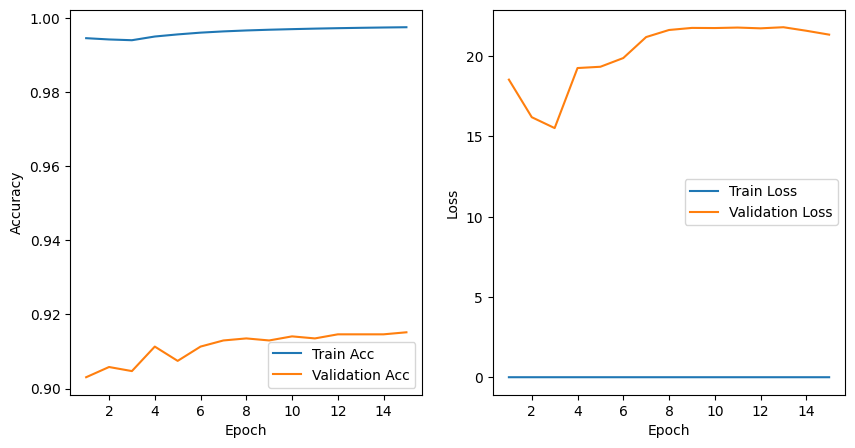

In [50]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

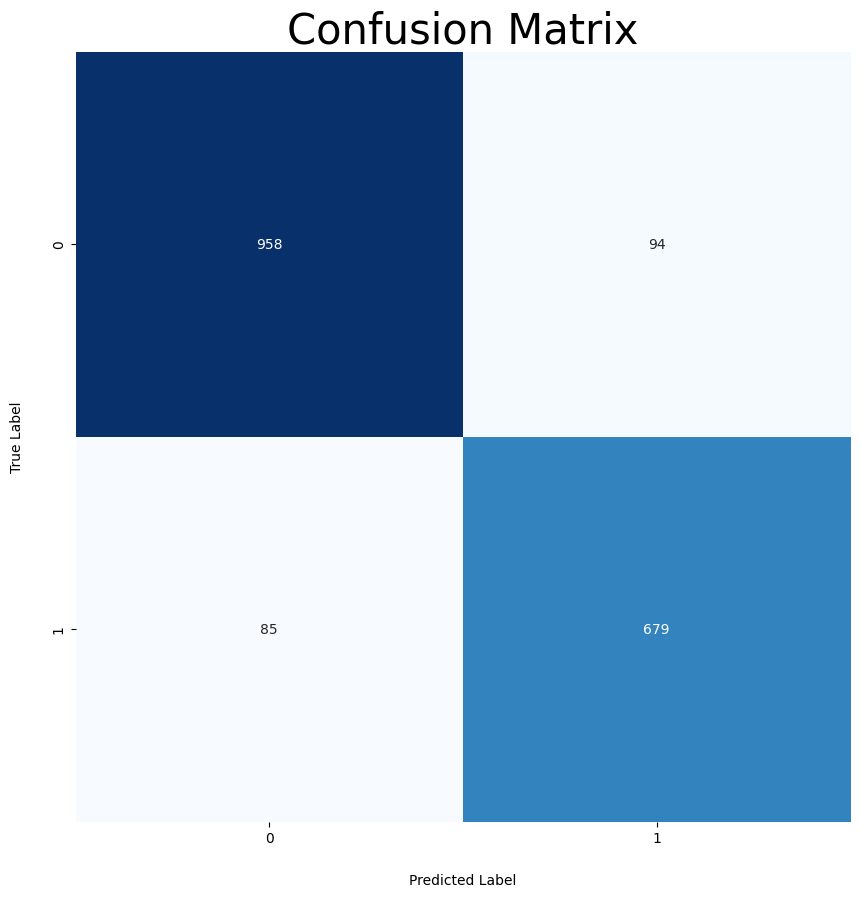

In [42]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [43]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.900
F1:        0.899
Precision: 0.898
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1052
           1       0.88      0.89      0.88       764

    accuracy                           0.90      1816
   macro avg       0.90      0.90      0.90      1816
weighted avg       0.90      0.90      0.90      1816

